In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import pickle


In [2]:
df = pd.read_csv("online_retail.csv")

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.dropna(subset=['CustomerID'], inplace=True)

In [4]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [5]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [6]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [7]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

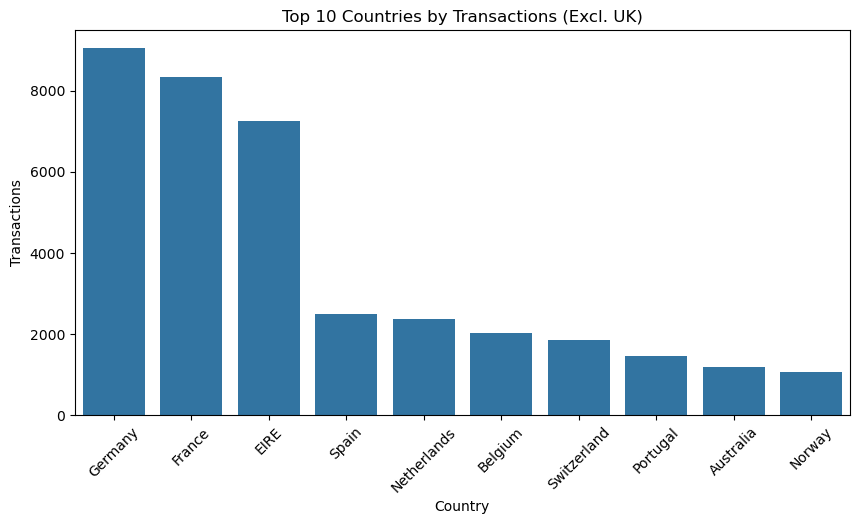

In [8]:
top_countries = df[df['Country'] != 'United Kingdom']['Country'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title("Top 10 Countries by Transactions (Excl. UK)")
plt.ylabel("Transactions")
plt.xticks(rotation=45)
plt.show()

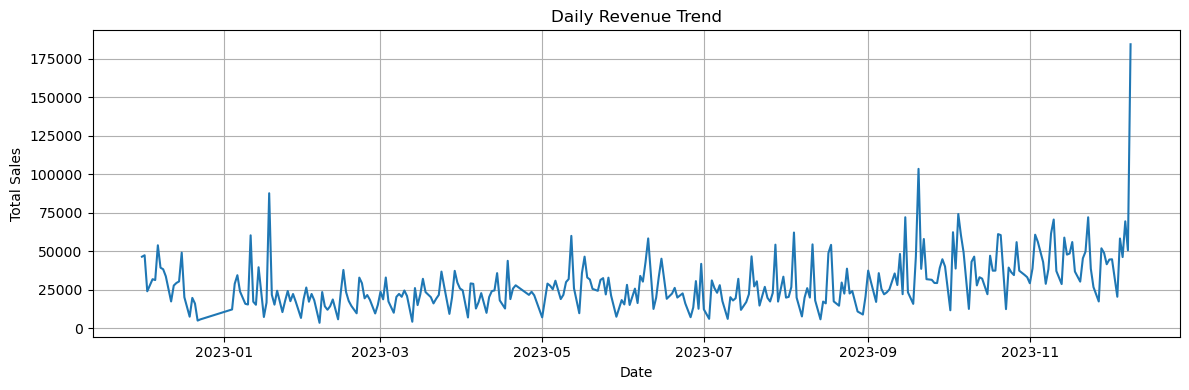

In [9]:
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalAmount'].sum()
daily_sales.plot(figsize=(12,4))
plt.title("Daily Revenue Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
last_pur_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (last_pur_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).reset_index()


In [11]:
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [12]:
rfm_log = np.log1p(rfm[['Recency', 'Frequency', 'Monetary']])


In [13]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

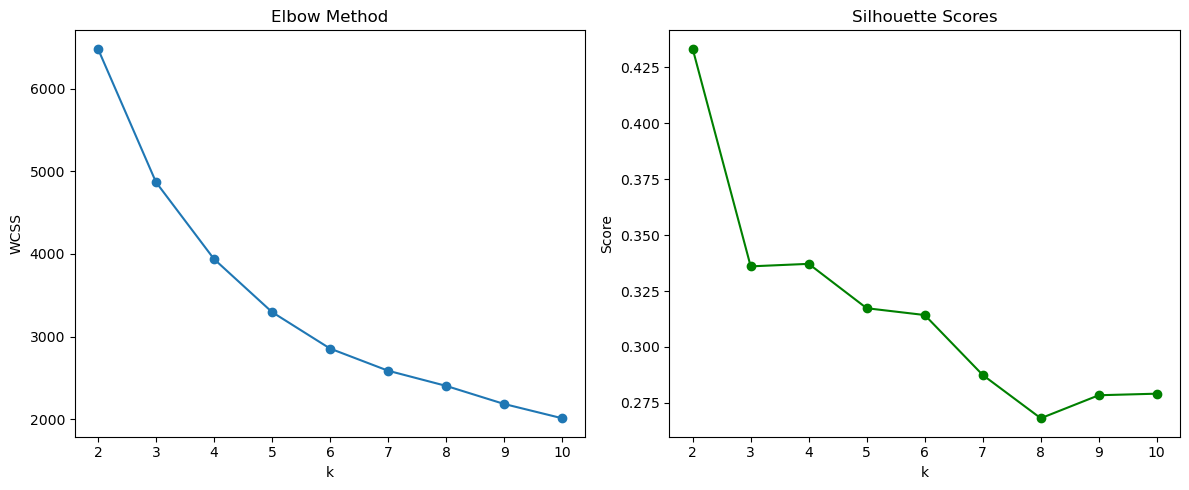

In [14]:
wcss = []
sil_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(K, wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(K, sil_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('k')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [15]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


In [16]:
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
print(cluster_summary)

         Recency  Frequency  Monetary
Cluster                              
0          18.12       2.15    551.82
1          12.13      13.71   8074.27
2          71.08       4.08   1802.83
3         182.50       1.32    343.45


In [17]:
def label_cluster(row):
    if row['Cluster'] == 1:
        return "🟢 High-Value"
    elif row['Cluster'] == 0:
        return "🔵 Occasional"
    elif row['Cluster'] == 2:
        return "🟡 Regular"
    else:
        return "🔴 At-Risk"

rfm['Segment'] = rfm.apply(label_cluster, axis=1)


In [18]:
rfm_model = {
    'scaler': scaler,
    'model': kmeans
}


In [19]:
with open("rfm_kmeans_model.pkl", "wb") as f:
    pickle.dump(rfm_model, f)

print("Saved RFM model to 'rfm_kmeans_model.pkl'")


Saved RFM model to 'rfm_kmeans_model.pkl'


In [20]:
customer_product = df.pivot_table(
    index='CustomerID',
    columns='StockCode',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

In [21]:
similarity = cosine_similarity(customer_product.T)
similarity_df = pd.DataFrame(similarity, index=customer_product.columns, columns=customer_product.columns)


In [22]:
desc_map = df[['StockCode', 'Description']].drop_duplicates().dropna()
code_to_desc = desc_map.set_index('StockCode')['Description']
desc_to_code = desc_map.set_index('Description')['StockCode']


In [53]:
product_bundle = {
    "product_similarity_df": similarity_df,
    "code_to_desc": code_to_desc,
    "desc_to_code": desc_to_code
}

with open("product_recommender.pkl", "wb") as f:
    pickle.dump(product_bundle, f)

print("Product recommender model saved as dictionary.")


Product recommender model saved as dictionary.


In [57]:
import pickle

with open("product_recommender.pkl", "rb") as f:
    product_model = pickle.load(f)

print(product_model.keys())  # Should show: dict_keys(['product_similarity_df', 'code_to_desc', 'desc_to_code'])


dict_keys(['product_similarity_df', 'code_to_desc', 'desc_to_code'])
